In [9]:
import os, glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from ase.db import connect
from ase import io

from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# ToDo

- [x] make spainn database for geom0 and geom10 and add the labels 'cis' or 'trans' to every datapoint
- [x] make db from interpolated geoms and give the labels 'inter'
- [x] merge the databases

all these steps are done on the cluster

```/home/users/camuller/04_cyanine-project/04_hc-Cy1/cis/gen_spainnDB_cis.py``` (cis/tranbs/inter folder)

```/home/users/camuller/04_cyanine-project/04_hc-Cy1/merge_cis_trans_inter_db.py```

- [x] read now merged database with these labels for every entry
- [x] write an additional function, that generates a list (of length n_samples) with labels
- [x] add column to pandas dataframe with labels use them for color-coding the PCA plot
- [x] add color coding in plotting
- [ ] write generalized plotting function
  

In [10]:
def r2_descriptor(xyz_matrix: np.ndarray) -> np.ndarray:
    """Build the pairwise atom-atom distance descriptor.

    Args:
    -----
        xyz_matrix: a numpy 3D tensor of shape (n_geometries, n_atoms, 3) containing the stacked 
                    Cartesian coordinates of the molecular structures.

    Return:
    -------
        r2_matrix: a numpy 2D array of shape (n_geometries, n_atoms * (n_atoms - 1)/2) with the
                   unique pairwise distances vector calculated for each molecular geometry.
    """
    n_samples, n_atoms, _ = xyz_matrix.shape
    dist_vec_size = int(n_atoms * (n_atoms - 1)/2)
    r2_matrix = np.empty((n_samples, dist_vec_size))
    for idx in range(n_samples):
        distance_matrix = np.zeros((n_atoms, n_atoms))
        geom = xyz_matrix[idx]
        for i, j in combinations(range(len(geom)), 2):
            R = np.linalg.norm(geom[i] - geom[j])
            distance_matrix[j, i] = R
        r2_vector = distance_matrix[np.tril_indices(len(distance_matrix), -1)]
        r2_matrix[idx, :] = r2_vector.reshape(1,-1)
    return r2_matrix
    

In [11]:
def _get_xyz_from_db(datapath, dbname):
   
    ase_db = connect(os.path.join(datapath, dbname))
    n_samples = len(ase_db)
    n_atoms = [row.toatoms().get_global_number_of_atoms() for row in ase_db.select()]
    
    if len(set(n_atoms)) == 1:
        n_atoms = n_atoms[0]
    else:
        raise Exception('''Not all molecules in the database have the same number of atoms. 
            Did you mix databases of different molecules?''')
        
    xyz_matrix = np.array([mol.toatoms().get_positions() for idx, mol in enumerate(ase_db.select())])
    
    return xyz_matrix
    

In [12]:
def _get_conf_from_db(datapath, dbname):
   
    ase_db = connect(os.path.join(datapath, dbname))
    labels = []
    for row in ase_db.select():
        labels.append(row.data['conf'])

    return labels

In [13]:
   
def _get_path_from_db(datapath, dbname, pathXYZname, db_unit='Bohr', path_unit='Angstrom'):

    if db_unit == path_unit:
        conv_path = 1.0
    else:
        if db_unit == 'Bohr' and path_unit == 'Angstrom':
            conv_path = 1/0.52917721067
        else:
            conv_path = 0.52917721067

    path_label = ['no' for _ in range(len(connect(os.path.join(datapath, dbname))))]
    ase_path = io.read(pathXYZname, index=':')
    
    for i, mol_path in enumerate(ase_path):
        path_xyz = mol_path.get_positions()*conv_path
        with connect(os.path.join(datapath, dbname)) as db:
            for j, mol in enumerate(db.select()):
                curr_xyz = mol.toatoms().get_positions()
                if np.allclose(path_xyz, curr_xyz):
                    path_label[j] = 'yes'

    with connect(os.path.join(datapath, dbname)) as db_n:
        for j, mol in enumerate(db_n.select()):
            data = mol.data
            data['path'] = path_label[j]
            db_n.update(mol.id, data=data)

    return path_label



In [15]:

path = os.getcwd()
databases = sorted([n for n in os.listdir(path) if 'Cy' in n and n.endswith('.db')])
molnames = []

df_pca = []
for db in databases:
    mol = db.split('_')[1][:-3]
    molnames.append(mol)
    
    print("=================================================")
    print("Loading geometries for molecules "+str(db[:-3]))
    print("=================================================\n")
    xyz_matrix = _get_xyz_from_db(path, db)
    
    # Configuration labels (cis/trans/inter)
    conf_labels = _get_conf_from_db(path,db)
    
    # get labels if molecule is on initial path or sampled (path=yes/no)
    path_name = str(mol)+'_path.xyz'
    path_labels = _get_path_from_db(datapath=path, 
                                    dbname=db, 
                                    pathXYZname=path_name, 
                                    db_unit='Bohr', 
                                    path_unit='Angstrom'
                                   )
    
    print("Calculating the inverse R2 descriptor...\n")
    r2 = r2_descriptor(xyz_matrix)
    print("Number of samples = {}".format(r2.shape[0]))
    print("Number of features = {}".format(r2.shape[1]))
    print(" ")
    #conformations = np.unique(data['CONF'])
    #print("Conformations ---> {}\n".format(conformations))
    X = MinMaxScaler().fit_transform(r2)
    print("Performing dimensionality reduction with PCA...\n")
    pca_n2 = PCA(n_components=2)
    pca_n2.fit(X)
    X_transformed = pca_n2.transform(X)
    print("*************************")
    print("Explained variance ratio")
    print("*************************")
    print(" ")
    print(pca_n2.explained_variance_ratio_)
    print(" ")
    col_names = [mol + '_pc1', mol + '_pc2']
    df = pd.DataFrame(X_transformed, columns=col_names)
    df[mol + '_conf'] = conf_labels
    df[mol + '_path'] = path_labels
    df_pca.append(df)

df_pca = pd.concat(df_pca, axis=1)
print("Saving all data to a compressed csv file\n")
compression_opts = dict(method='zip', archive_name=str(mol)+'_pca.csv')
df_pca.to_csv('pca.zip', index=False, header=True, compression=compression_opts)

print("FINISHED!")


Loading geometries for molecules 3Sing_cc-Cy2

Calculating the inverse R2 descriptor...

Number of samples = 1110
Number of features = 561
 
Performing dimensionality reduction with PCA...

*************************
Explained variance ratio
*************************
 
[0.44559637 0.04587114]
 
Loading geometries for molecules 3Sing_hc-Cy1

Calculating the inverse R2 descriptor...

Number of samples = 1108
Number of features = 351
 
Performing dimensionality reduction with PCA...

*************************
Explained variance ratio
*************************
 
[0.43027987 0.03879372]
 
Loading geometries for molecules 3Sing_hc-Cy2

Calculating the inverse R2 descriptor...

Number of samples = 1110
Number of features = 465
 
Performing dimensionality reduction with PCA...

*************************
Explained variance ratio
*************************
 
[0.52507934 0.02917086]
 
Loading geometries for molecules 3Sing_sc-Cy1

Calculating the inverse R2 descriptor...

Number of samples = 1111
N

### Make Plots

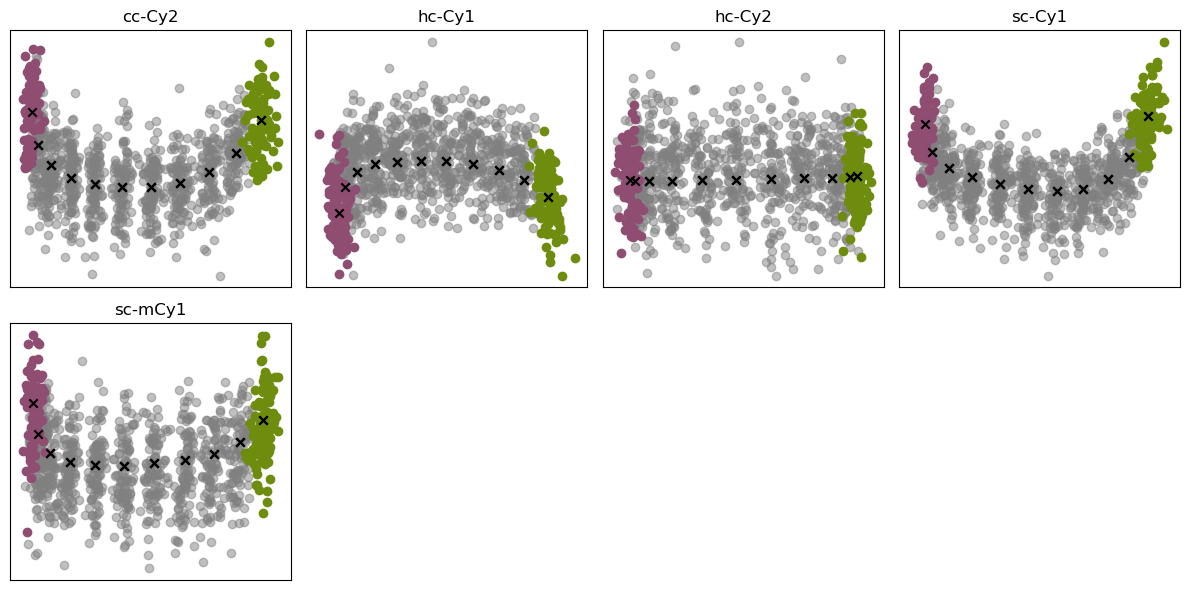

In [27]:
c_green  = (110/255, 140/255, 14/255)
c_purple = (143/255, 78/255, 113/255)
c_blue   = (85/255, 118/255, 158/255)

# Determine the number of rows and columns for the subplot grid
num_plots = len(molnames)
num_cols = 4
num_rows = -(-num_plots // num_cols)

# Mapping non-numerical categories to colors
colors = {'inter': 'grey', 'cis': c_green, 'trans': c_purple}

# delete NaN values from df
df_clean = df_pca.dropna()

# Create the subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(3*num_cols, 3*num_rows))

# Flatten the axs array if it's a 2D array
axs = axs.flatten()

# Iterate through molecule names and plot on each subplot
for i, mol in enumerate(molnames):
    row = i // num_cols
    col = i % num_cols

    ax = axs[i]
    conf_col = df_clean[mol+'_conf']
    path_col = df_clean[mol+'_path']

    # Sample logic to determine colors based on conditions
    for condition, color in colors.items():
        subset_indices = conf_col[conf_col == condition].index
        ax.scatter(df_clean.loc[subset_indices, mol+'_pc1'], df_clean.loc[subset_indices, mol+'_pc2'], 
                   #label=condition if not condition=='inter' else None, 
                   color=color, alpha=0.5 if condition == 'inter' else 1.0)

        subset_idxs = path_col[path_col == 'yes'].index
        ax.scatter(df_clean.loc[subset_idxs, mol+'_pc1'], df_clean.loc[subset_idxs, mol+'_pc2'], 
                   color='black', marker='x')

    ax.set_title(mol)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.legend()

# Remove empty subplots if any
if num_plots < num_rows * num_cols:
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axs[i])

plt.tight_layout()
#plt.show()

plt.savefig('cyanines_PCAplot.pdf')